In [29]:
import pandas as pd
import numpy as np
gas_data = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv", index_col=0)
gas_data = gas_data.rename(columns={"Price": "Gas_Price"})
gas_data.columns

Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Gas_Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

In [30]:
gas_data = gas_data[["Gas_Price", "Brent_Price", "Date"]]
gas_data

,Gas_Price,Brent_Price,Date
0,1.272,25.280,2000-01-03
1,1.264,23.468,2000-01-10
2,1.277,24.988,2000-01-17
3,1.315,26.588,2000-01-24
4,1.316,27.000,2000-01-31
...,...,...,...
1247,3.238,80.868,2023-11-27
1248,3.231,80.648,2023-12-04
1249,3.136,75.500,2023-12-11
1250,3.053,76.206,2023-12-18


In [31]:
stock_data = pd.read_csv("datathon data/all_stocks_and_etfs.csv")
stock_data.columns

Index(['Date-Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker_Symbol'], dtype='object')

In [32]:
gas_data["Date"] = pd.to_datetime(gas_data["Date"])
stock_data["Date"] = pd.to_datetime(stock_data["Date-Time"])

label_col = 'Close'
lag = 1
stock_data[f'Close_lag_{lag}'] = stock_data['Close'].shift(lag)

stock_data = stock_data[["Date", "Ticker_Symbol", f'Close_lag_{lag}', label_col]]
stock_data

,Date,Ticker_Symbol,Close_lag_1,Close
0,2024-01-25,HAL,NaN,37.0000
1,2024-01-24,HAL,37.0000,36.8300
2,2024-01-23,HAL,36.8300,35.3000
3,2024-01-22,HAL,35.3000,34.4300
4,2024-01-19,HAL,34.4300,33.9700
...,...,...,...,...
144553,1999-11-05,SPY,138.0000,137.8750
144554,1999-11-04,SPY,137.8750,136.5312
144555,1999-11-03,SPY,136.5312,135.5000
144556,1999-11-02,SPY,135.5000,134.5937


align time between the 2datasets:

In [33]:
df = pd.merge(
    left=stock_data,
    right=gas_data,
    on="Date",
    how="inner"
)
df = df.dropna()
df.to_csv("datathon data/stock_data.csv", index=False)
df

,Date,Ticker_Symbol,Close_lag_1,Close,Gas_Price,Brent_Price
0,2023-12-18,HAL,36.8200,36.2100,3.053,76.206
1,2023-12-11,HAL,34.4400,34.7700,3.136,75.500
2,2023-12-04,HAL,36.3300,37.3700,3.231,80.648
3,2023-11-27,HAL,37.5200,37.6900,3.238,80.868
4,2023-11-20,HAL,38.2100,38.2000,3.289,81.760
...,...,...,...,...,...,...
26821,2000-02-07,SPY,144.3125,142.3750,1.325,27.504
26822,2000-01-31,SPY,140.9375,139.5625,1.316,27.000
26823,2000-01-24,SPY,141.9375,140.3437,1.315,26.588
26824,2000-01-10,SPY,144.5000,146.2500,1.264,23.468


In [34]:
codes, uniques = pd.factorize(df["Ticker_Symbol"])
df["Ticker_Symbol"] = codes + 1

num_to_stock = {code + 1: symbol for code, symbol in enumerate(uniques)}
stock_to_num = {symbol: code + 1 for code, symbol in enumerate(uniques)}
print(num_to_stock)
print(stock_to_num)

{1: 'HAL', 2: 'FANG', 3: 'E', 4: 'EXC', 5: 'HES', 6: 'BKR', 7: 'BPT', 8: 'VLO', 9: 'CVX', 10: 'OXY', 11: 'KMI', 12: 'PSX', 13: 'NOV', 14: 'CHK', 15: 'MPC', 16: 'DVN', 17: 'COP', 18: 'EPD', 19: 'BP', 20: 'XOM', 21: 'EOG', 22: 'CEO', 23: 'SLB', 24: 'WMB', 25: 'ONEQ', 26: 'DIA', 27: 'VOO', 28: 'SPY'}
{'HAL': 1, 'FANG': 2, 'E': 3, 'EXC': 4, 'HES': 5, 'BKR': 6, 'BPT': 7, 'VLO': 8, 'CVX': 9, 'OXY': 10, 'KMI': 11, 'PSX': 12, 'NOV': 13, 'CHK': 14, 'MPC': 15, 'DVN': 16, 'COP': 17, 'EPD': 18, 'BP': 19, 'XOM': 20, 'EOG': 21, 'CEO': 22, 'SLB': 23, 'WMB': 24, 'ONEQ': 25, 'DIA': 26, 'VOO': 27, 'SPY': 28}


### Train XGBoost and Random Forest

**Aim**: build a predictive model for stock (log-return or pct change).


**Approach**:
- Use XGBoost for prediction.
- Extract feature importances to assess which factors matter most.

In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
feature_cols = ["Gas_Price", "Brent_Price", "Ticker_Symbol", f'Close_lag_{lag}']
label_col = 'Close'
X = df[feature_cols]
y = df[label_col]

print(X)
print(y)

       Gas_Price  Brent_Price  Ticker_Symbol  Close_lag_1
0          3.053       76.206              1      36.8200
1          3.136       75.500              1      34.4400
2          3.231       80.648              1      36.3300
3          3.238       80.868              1      37.5200
4          3.289       81.760              1      38.2100
...          ...          ...            ...          ...
26821      1.325       27.504             28     144.3125
26822      1.316       27.000             28     140.9375
26823      1.315       26.588             28     141.9375
26824      1.264       23.468             28     144.5000
26825      1.272       25.280             28     139.7500

[26826 rows x 4 columns]
0         36.2100
1         34.7700
2         37.3700
3         37.6900
4         38.2000
           ...   
26821    142.3750
26822    139.5625
26823    140.3437
26824    146.2500
26825    145.4375
Name: Close, Length: 26826, dtype: float64


In [47]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X = pd.DataFrame(
    std_scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

y = pd.Series(
    std_scaler.fit_transform(y.values.reshape(-1, 1)).ravel(),
    index=y.index,
    name=y.name
)

print(X)
print(y)

       Gas_Price  Brent_Price  Ticker_Symbol  Close_lag_1
0       0.502439     0.301432       -1.69242    -0.606023
1       0.609509     0.276973       -1.69242    -0.641837
2       0.732060     0.455322       -1.69242    -0.613397
3       0.741090     0.462943       -1.69242    -0.595490
4       0.806881     0.493846       -1.69242    -0.585107
...          ...          ...            ...          ...
26821  -1.726694    -1.385814        1.60779     1.011488
26822  -1.738304    -1.403275        1.60779     0.960702
26823  -1.739594    -1.417548        1.60779     0.975750
26824  -1.805385    -1.525639        1.60779     1.014310
26825  -1.795065    -1.462863        1.60779     0.942833

[26826 rows x 4 columns]
0       -0.614735
1       -0.636424
2       -0.597264
3       -0.592445
4       -0.584764
           ...   
26821    0.984241
26822    0.941882
26823    0.953647
26824    1.042604
26825    1.030366
Name: Close, Length: 26826, dtype: float64


In [48]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=421)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))

ypredtrain = model.predict(X_train)
print("Train MSE:", mean_squared_error(y_train, ypredtrain))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

Test MSE: 0.0014572378131849576
Train MSE: 0.00036816227392956344
Feature Importantce          feature  importance
3    Close_lag_1    0.998723
2  Ticker_Symbol    0.000470
1    Brent_Price    0.000426
0      Gas_Price    0.000381


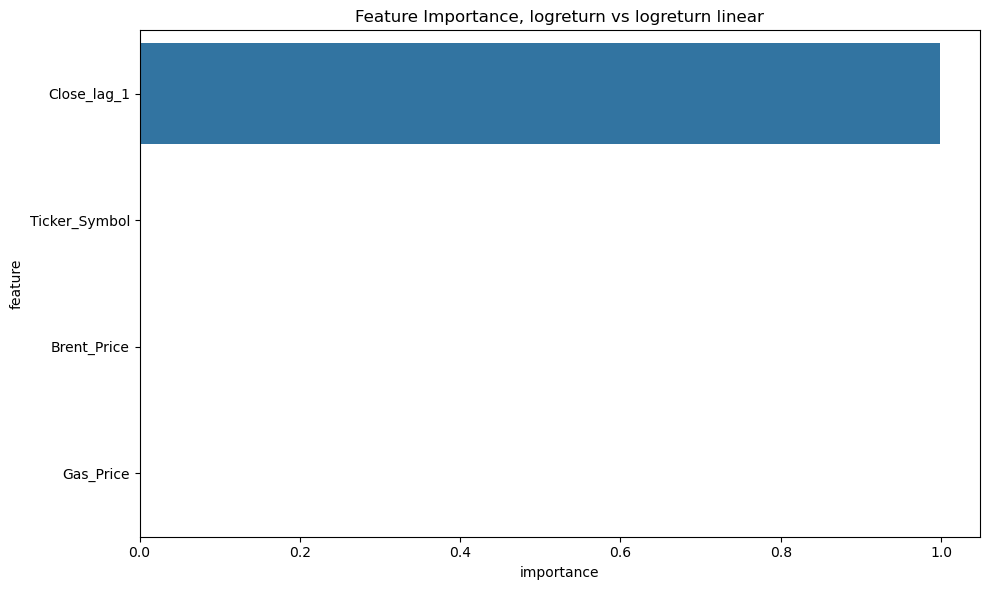

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.title("Feature Importance, logreturn vs logreturn linear")
plt.tight_layout()
plt.show()

In [40]:
# install with: pip install pytorch_tabnet
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.metrics import mean_squared_error

# Assume X, y are your feature matrix and target (numpy or pandas)
# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values.reshape(-1,1),
    test_size=0.2, random_state=42
)

# 2) Initialize TabNet for regression
#    key params: n_d/n_steps adjust model capacity
model = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax'  # or 'entmax'
)

# 3) Fit
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train','test'],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 4) Predict & evaluate
y_pred = model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))

# 5) Extract global feature importances
#    attribute `feature_importances_` is a numpy array of shape (n_features,)
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("TabNet Feature Importances:\n", feat_imp.head(10))


/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8561.19193| train_rmse: 157.416 | test_rmse: 156.5361|  0:00:01s
epoch 1  | loss: 4506.80003| train_rmse: 183.13398| test_rmse: 181.22318|  0:00:03s
epoch 2  | loss: 2474.4307| train_rmse: 149.86475| test_rmse: 148.06313|  0:00:05s
epoch 3  | loss: 2317.79109| train_rmse: 160.41985| test_rmse: 159.17928|  0:00:08s
epoch 4  | loss: 2229.61846| train_rmse: 100.57192| test_rmse: 99.54575|  0:00:09s
epoch 5  | loss: 2213.65553| train_rmse: 86.58041| test_rmse: 87.23562|  0:00:11s
epoch 6  | loss: 2086.27763| train_rmse: 72.72724| test_rmse: 73.56948|  0:00:13s
epoch 7  | loss: 2072.71511| train_rmse: 64.34655| test_rmse: 65.28735|  0:00:15s
epoch 8  | loss: 1989.0238| train_rmse: 77.18663| test_rmse: 77.31769|  0:00:16s
epoch 9  | loss: 1956.32634| train_rmse: 72.14615| test_rmse: 73.54694|  0:00:18s
epoch 10 | loss: 1916.43972| train_rmse: 60.24338| test_rmse: 61.12766|  0:00:19s
epoch 11 | loss: 1861.29714| train_rmse: 56.6224 | test_rmse: 57.2436 |  0:00:22s
epoch 12 | 

/home/love/home/miniforge/envs/env0/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test MSE: 1218.7982682712952
TabNet Feature Importances:
          feature  importance
0  Ticker_Symbol    0.377782
1    Brent_Price    0.332030
2      Gas_Price    0.290188
